# Regression and Gauss-Markov assumptions

For this exercise, we recommend using `statsmodels`. 
Unless you haven't already installed it, you can do so by running
```bash
pip install statsmodels
```

*Make sure you have activated your `baml-venv` environment before doing so!*

## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("gauss-markov.csv")
data.head(10)

,x1,x2,x3,y
0,-10.000000,13.593745,-86.999140,212.205325
1,-9.899497,6.640181,-56.314647,185.576520
2,-9.798995,11.001845,-77.000938,201.213858
3,-9.698492,9.754249,-70.062754,193.069946
4,-9.597990,12.606083,-81.346834,200.385392
5,-9.497487,12.596451,-82.014682,197.140433
6,-9.396985,5.579366,-50.366159,170.293901
7,-9.296482,3.062096,-39.131473,158.506427
8,-9.195980,6.999276,-55.432802,170.484964
9,-9.095477,11.487830,-75.768802,181.682421


## a)

We start by using the simple linear regression model
$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3
$$

Using [``sm.OLS``](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html), compute optimal values for the parameters.

> Note: You may want to use ``sm.add_constant`` to add values for the intercept.



In [3]:
# Prepare input data
X = sm.add_constant(data[["x1", "x2", "x3"]])
y = data["y"]

In [4]:
# Fit a linear model with statsmodels
model = sm.OLS(y, X)
results = model.fit()

In [5]:
# Show the results using the summary() function
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     128.6
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           4.52e-46
Time:                        11:49:26   Log-Likelihood:                -963.30
No. Observations:                 200   AIC:                             1935.
Df Residuals:                     196   BIC:                             1948.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.7239      6.241      5.083      0.0

Use the model to predict the $y$-values

In [6]:
predicted_values = model.predict(results.params, X)

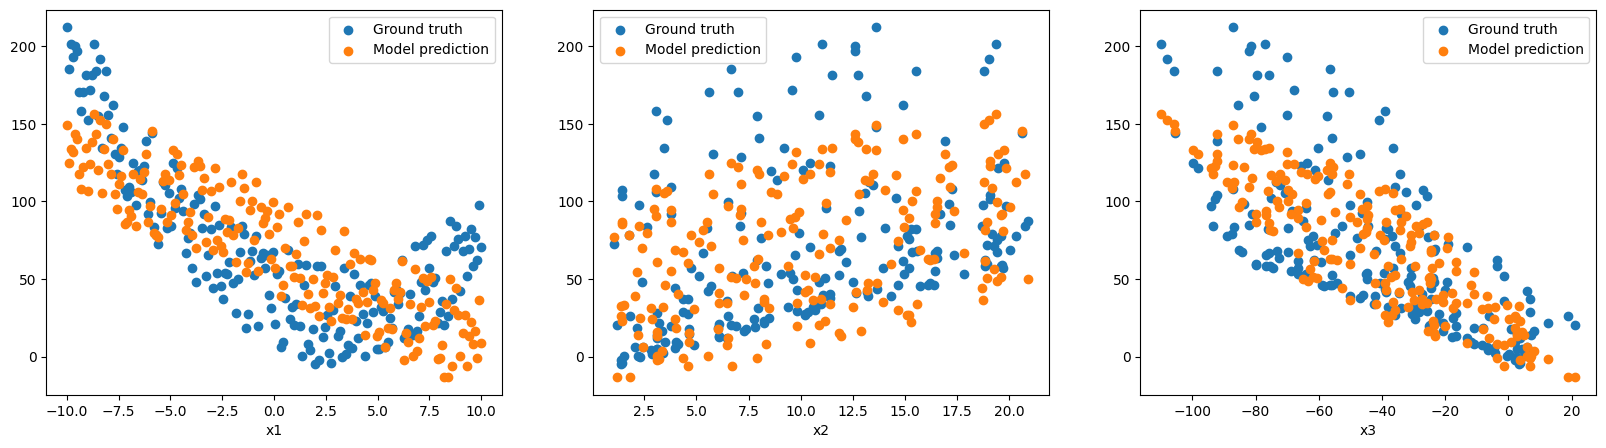

In [7]:
# Visualization of the predicted variables vs. the true variables
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for ax, variable_name in zip(axs, ["x1", "x2", "x3"]):
    ax.scatter(data[variable_name], data["y"], label="Ground truth")
    ax.scatter(data[variable_name], predicted_values, label="Model prediction")
    ax.legend()
    ax.set_xlabel(variable_name)

## b)

Compute the residuals $e = \hat{y} - y$ of the resulting model.

In [8]:
residuals = data["y"] - predicted_values
# alternatively: residuals = results.resid

Plot the residuals over the input variables $x_1$ and $x_2$. What do you observe?

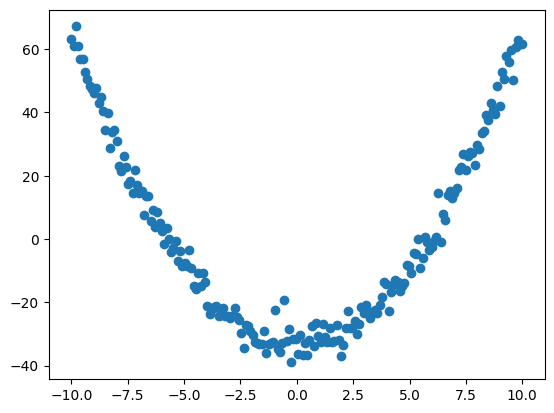

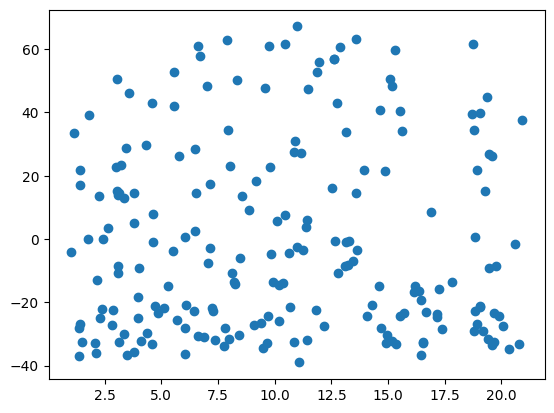

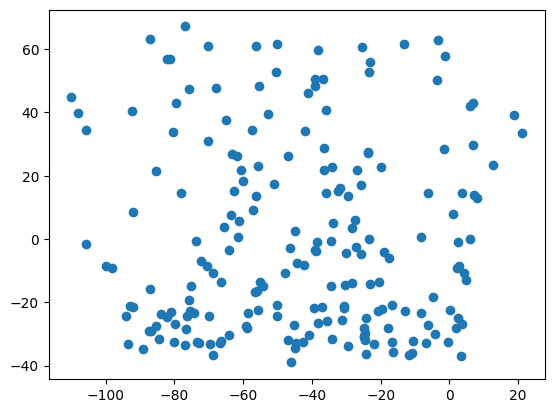

In [9]:
plt.figure()
plt.scatter(data["x1"], residuals)
plt.figure()
plt.scatter(data["x2"], residuals)
plt.figure()
plt.scatter(data["x3"], residuals)

Using a White test ([`statsmodels.stats.diagnostic.het_white`](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_white.html)), show that we can reject the hypothesis of homoscedastic residuals at an $\alpha$ level of 0.01.

In [10]:
from statsmodels.stats.diagnostic import het_white

statistic, p_value, _, _ = het_white(residuals, X)
print(f"Value of the null-hypothesis that the residuals are homoscedastic: {statistic}")
print(f"p-value of the statistic: {p_value}")

Value of the null-hypothesis that the residuals are homoscedastic: 73.74388209470568
p-value of the statistic: 2.7960490474646e-12


## c)

Consider the alternative model
$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_1^2
$$

Compute the optimal parameter values. You should observe that the $R^2$ value improves drastically over the previous model.

In [11]:
# Prepare input data
X = sm.add_constant(data[["x1", "x2", "x3"]])
X["x1^2"] = np.square(X["x1"])
y = data["y"]

# Fit a linear model
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.329e+05
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:49:28   Log-Likelihood:                -280.99
No. Observations:                 200   AIC:                             572.0
Df Residuals:                     195   BIC:                             588.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9063      0.217     18.032      0.0

Although this model gives a very good fit of the data, there is another problem.
Use the Variance inflation factor ([`statsmodels.stats.outliers_influence.variance_inflation_factor`](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)) to check whether the variables are dependent.

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

for index, variable_name in enumerate(X.columns):
    if variable_name == "const": 
        continue
    print(f"VIF for variable {variable_name} is {vif(X, index)}")

VIF for variable x1 is 355.3505135936152
VIF for variable x2 is 752.4661591277431
VIF for variable x3 is 1080.2717686551946
VIF for variable x1^2 is 1.01131465363082


In [13]:
# Bonus: Check if residuals are now homoscedastic
from statsmodels.stats.diagnostic import het_white

statistic, p_value, _, _ = het_white(results.resid, X)
print(f"Value of the null-hypothesis that the residuals are homoscedastic: {statistic}")
print(f"p-value of the statistic: {p_value}")

Value of the null-hypothesis that the residuals are homoscedastic: 16.36732230570952
p-value of the statistic: 0.229862184929788


## d)
Consider a third model:
$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1^2
$$

Compute the optimal parameter values.

In [14]:
# Prepare input data
X = sm.add_constant(data[["x1", "x2"]])
X["x1^2"] = np.square(X["x1"])
y = data["y"]

# Fit a linear model
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.062e+05
Date:                Tue, 17 Dec 2024   Prob (F-statistic):          2.26e-314
Time:                        11:49:28   Log-Likelihood:                -332.70
No. Observations:                 200   AIC:                             673.4
Df Residuals:                     196   BIC:                             686.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3017      0.214     10.758      0.0

Check if the model has multicollinear input variables using the VIF.

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

for index, variable_name in enumerate(X.columns):
    if variable_name == "const": 
        continue
    print(f"VIF for variable {variable_name} is {vif(X, index)}")

VIF for variable x1 is 1.0006668672411938
VIF for variable x2 is 1.000884608699781
VIF for variable x1^2 is 1.000217741458587


Check if the model satisfies the homoscedasticity assumption using the White test and an $\alpha$ level of 0.01.

In [16]:
from statsmodels.stats.diagnostic import het_white

statistic, p_value, _, _ = het_white(results.resid, X)
print(f"Value of the null-hypothesis that the residuals are homoscedastic: {statistic}")
print(f"p-value of the statistic: {p_value}")

Value of the null-hypothesis that the residuals are homoscedastic: 4.314943637492608
p-value of the statistic: 0.8276492158992901


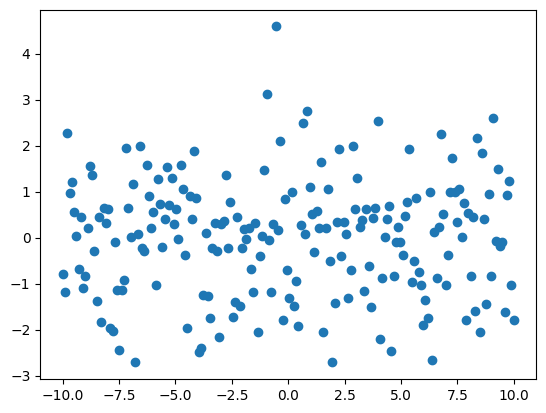

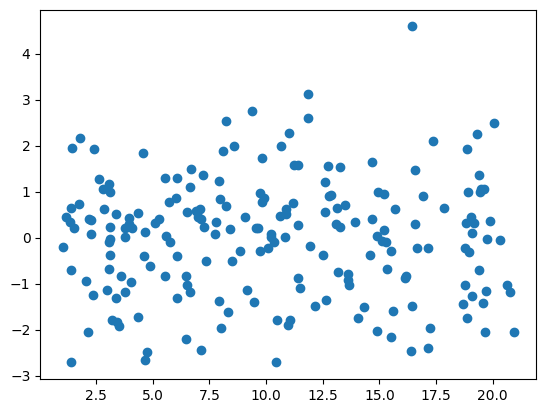

In [17]:
# Bonus: Visualization of the residuals
plt.figure()
plt.scatter(data["x1"], results.resid)
plt.figure()
plt.scatter(data["x2"], results.resid)

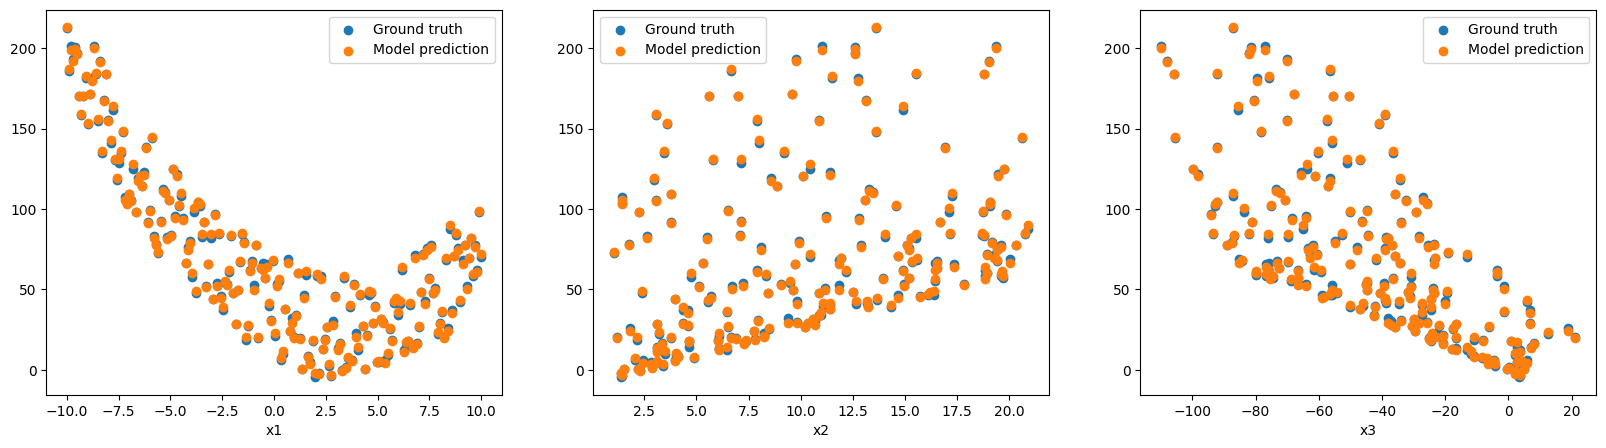

In [18]:
# Visualization of the predicted variables vs. the true variables
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for ax, variable_name in zip(axs, ["x1", "x2", "x3"]):
    ax.scatter(data[variable_name], data["y"], label="Ground truth")
    ax.scatter(data[variable_name], model.predict(results.params, X), label="Model prediction")
    ax.legend()
    ax.set_xlabel(variable_name)